# How to run an injection and recovery test

This injection and recovery tool allows you to inject many planetary transits or supernovae with random parameters in series. 

Let's start with an injections of planetary transits. We're going to download the TPF and lightcurve of a G-type star observed with Kepler.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from lightkurve import KeplerTargetPixelFile
import lightkurve.injection as inj
import numpy as np
import matplotlib.pyplot as plt

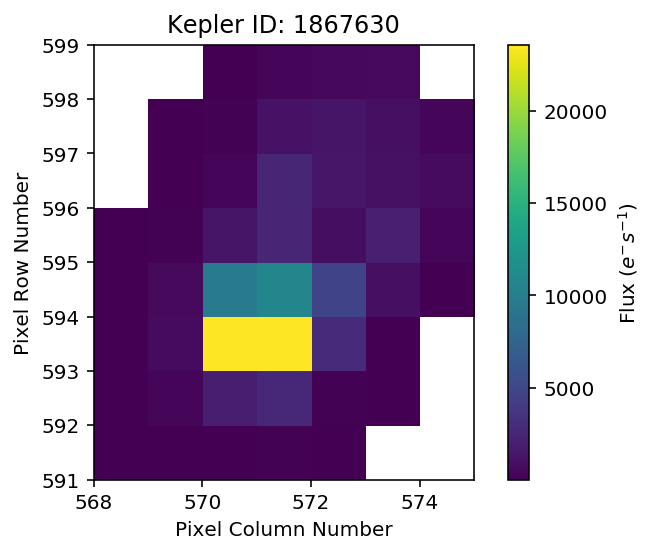

In [2]:
tpf_star = KeplerTargetPixelFile.from_archive(1867630, quarter=1)
tpf_star.plot()

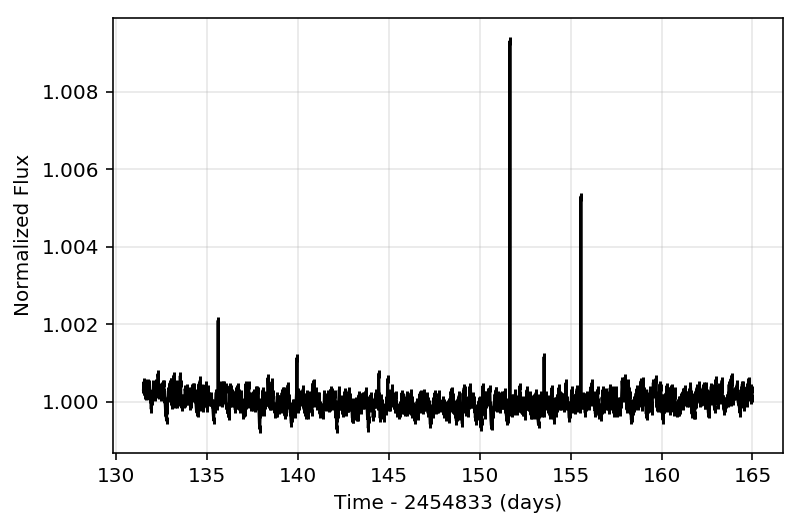

In [3]:
lc_star = tpf_star.to_lightcurve(aperture_mask='all')
lc_star.plot()

Let's normalize and detrend the lightcurve. It's important to normalize the lightcurve when injecting transits because the model to be injected is also normalized.

Text(0.5,0,'Time (days)')

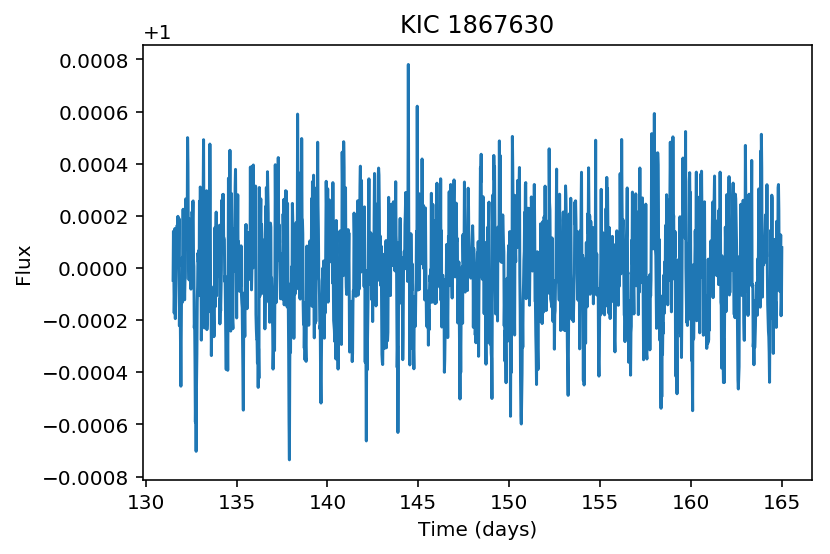

In [4]:
lc_star = lc_star.remove_nans().remove_outliers()
lc_star = lc_star.normalize().flatten()

plt.plot(lc_star.time, lc_star.flux)
plt.title('KIC 1867630')
plt.ylabel('Flux')
plt.xlabel('Time (days)')

To run an injection and recovery test, you need to specify a lightcurve to inject your signal into, the signal type (`Supernvoa` or `Planet`), number of iterations, a threshold for recovery (for example, demand that all fitted parameters must be within 5 percent of the injected parameters to be considered "recovered"), and random parameters to inject. 

The parameters we want to vary randomly are defined with Distribution classes in `lightkurve.injection`, which include the `UniformDistribution` and `GaussianDistribution` classes. We can set a parameter to a fixed value as well.  If we do not specify either a Distribution object or a fixed value, the parameter will be fixed to the default.  See the [docstring](https://github.com/ssagear/lightkurve/blob/injrec/lightkurve/injection.py) for default settings.

Here, we will inject 20 planets into this lightcurve and demand that all fitted parameters must be within 5 percent of the injected parameters.

In [6]:
table = lc_star.injection_and_recovery(
    signal_type="Planet", 
    ntests=20, 
    constr=0.05, 
    period=inj.UniformDistribution(5,10), 
    rprs=inj.UniformDistribution(0.1, 0.15), 
    inc=inj.GaussianDistribution(88,0.5))

This `.injection_and_recovery()` method returns an astropy table with all injected and fixed values, as well as a boolean to indicate whether the signal was recovered.

In [7]:
table

$Recovered$,$Period$,$Rp/Rs$,$To$,$inc$,$a$,$ecc$,$w$
float64,float64,float64,float64,float64,float64,float64,float64
0.0,5.1518141284317025,0.14513938659880757,5.0,88.48065929380552,15.0,0.0,90.0
0.0,5.469505868260801,0.14242163978979544,5.0,87.93515111311743,15.0,0.0,90.0
0.0,6.760945027318437,0.11117022948539684,5.0,88.07610625112166,15.0,0.0,90.0
0.0,7.41755512624961,0.12278401152551544,5.0,88.15980516189302,15.0,0.0,90.0
0.0,8.362879953061881,0.1361379971480412,5.0,87.55918154640126,15.0,0.0,90.0
0.0,6.684592386687674,0.11077464830030163,5.0,88.0255080748658,15.0,0.0,90.0
0.0,7.415128265335909,0.11847789464916499,5.0,88.77564506051694,15.0,0.0,90.0
0.0,7.5270489456924405,0.11729618187477517,5.0,87.62954938340935,15.0,0.0,90.0
1.0,5.7461385098849,0.11319981470762003,5.0,87.75410701729261,15.0,0.0,90.0


You can also run injections on a galaxy lightcurve with supernova signals. Let's download the TPF and lightcurve of a galaxy.

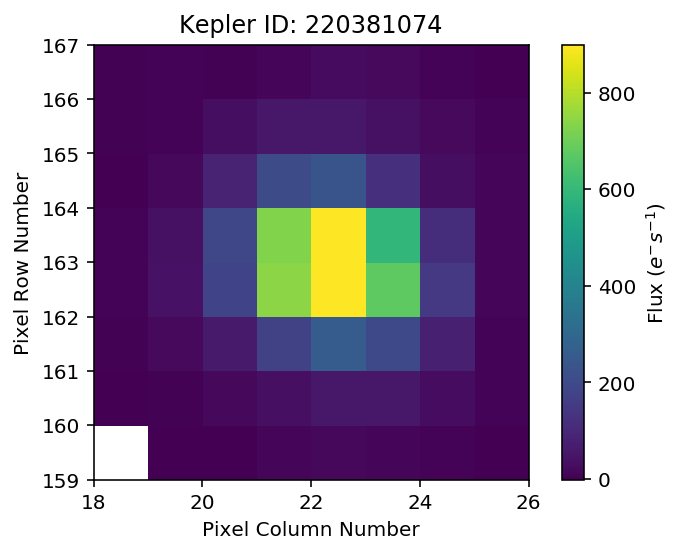

In [2]:
tpf = KeplerTargetPixelFile.from_archive(220381074)
tpf.plot()

Text(0.5,1,'EPIC 220381074')

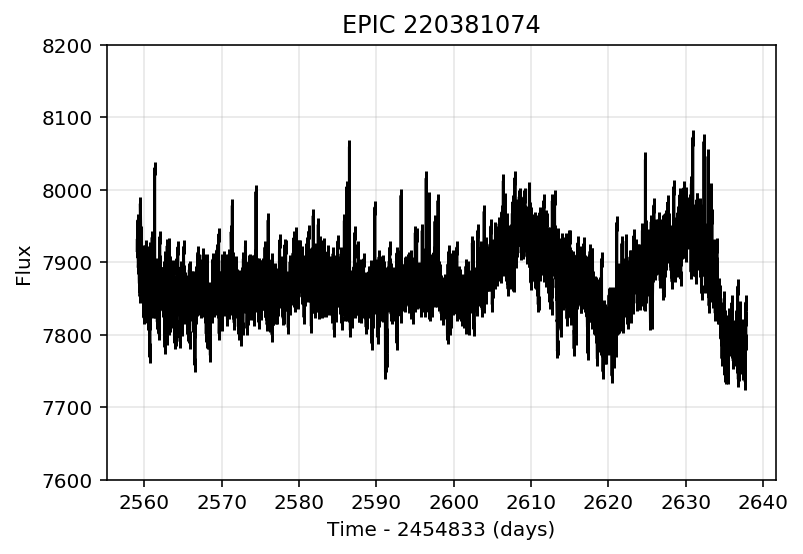

In [3]:
lc = tpf.to_lightcurve(aperture_mask='all')
#Remove nans and outliers
lc = lc.remove_nans().remove_outliers() 

lc.plot(normalize=False)
plt.ylim(7600, 8200)
plt.title('EPIC 220381074')

The injection and recoveries we are going to run vary amplitude and redshift, but keep T0 fixed.  We run 10 tests and demand the fitted parameters must be within 10 percent of the injected parameters. We can also specify an initial guess if we are working with supernovae.

In [26]:
table = lc.injection_and_recovery(
    signal_type="Supernova",
    ntests=10,
    constr=0.05,
    initial_guess={'T0':2610, 'amplitude':5.e-7, 'z':0.15, 'background':7800},
    T0=2600,
    amplitude=inj.UniformDistribution(2.e-7,8.e-7),
    z=inj.UniformDistribution(0.1, 0.2))

In [27]:
table

$Recovered$,$To$,$z$,$Amplitude$,$Background$
float64,float64,float64,float64,float64
0.0,2600.0,0.13632736790855327,2.1260596826424409e-07,7789.7870898437495
0.0,2600.0,0.16399282733682066,6.2493445636638e-07,7789.7870898437495
0.0,2600.0,0.1728545011387092,5.184028423684499e-07,7789.7870898437495
0.0,2600.0,0.19509396112047336,2.380445621572523e-07,7789.7870898437495
0.0,2600.0,0.14066425741986177,7.971122876556029e-07,7789.7870898437495
0.0,2600.0,0.13165064554700814,4.493794323520808e-07,7789.7870898437495
0.0,2600.0,0.1816423741864599,7.332484800124412e-07,7789.7870898437495
0.0,2600.0,0.19533409250814832,3.75397664928254e-07,7789.7870898437495
0.0,2600.0,0.19562393363416794,4.86627555729275e-07,7789.7870898437495
